In [112]:
import pickle
import os
import numpy as np

# Get metrics from the pickle file

In [113]:
experiment_path = r"C:\Users\yanni\Documents\ml_project2\experiments\test_unif_random"


# Load the variables
with open(os.path.join(experiment_path, "results\\nonnested_cval_mltsatt_l819.pkl"), 'rb') as f:
    results = pickle.load(f)

with open(os.path.join(experiment_path,'config.yaml'), 'rb') as f:
    config_info = pickle.load(f)

In [114]:
config_info

{'experiment': {'root_name': 'test1530/equal_balancing_oversampling/label_language',
  'name': '/2023_12_19_1/',
  'type': 4,
  'labels': 'binconcepts'},
 'data': {'key': 'break_sequence',
  'others': ({'gender': ['3', '4']},),
  'adjuster': {'limit': 819}},
 'ml': {'nfolds': 10,
  'epochs': 30,
  'oversampler': {'oversampling_factor': 1.5,
   'oversampling_col': ['label', 'language'],
   'rebalancing_mode': 'equal_balancing',
   'addyourownparameters': 'helloworld',
   'mode': 'augmentation'},
  'splitter': {'stratifier_col': ['stratifier_column']}},
 'seeds': {'splitter': 219, 'oversampler': 13, 'model': 139, 'numpy': 36},
 'mode': 'augmentation'}

In [115]:
print("Size original_TRAIN data:", len(results[1]["train_index"]),"(withouth the",len(results[1]["test_index"]),"used for TEST data)", "\n")
# Good to see if type of oversampling work well as leat dimensionality 
print("Size Total data after os:",len(results[1]["oversample_indexes"]),"(unique index of oversampling check if <",len(np.unique(np.array(results[1]["oversample_indexes"]))),"> equal to original_TRAIN size)","\n")

Size original_TRAIN data: 228 (withouth the 26 used for TEST data) 

Size Total data after os: 348 (unique index of oversampling check if < 228 > equal to original_TRAIN size) 



In [125]:
# Take the mean and std of our metrics acrross the 10 folds
roc = []
fp = []
language = []
for i in range(10):
    roc.append(results[i]["roc"])
    fp.append(results[i]["fp"])
    language.append(results[i]["language"])

print(language)

mean_roc = np.array(roc).mean()
std_roc = np.array(roc).std()
mean_fp = np.array(fp).mean()
std_fp = np.array(fp).std()

print(f"ROC: {np.mean(roc):.3f} +/- {np.std(roc):.3f}")
print(f"FP: {np.mean(fp):.3f} +/- {np.std(fp):.3f}")

[{'fn': {'Deutsch': 0.7142857142857143, 'Français': 0.6}, 'tn': {}, 'roc': {'Deutsch': 0.6071428571428571, 'Français': 0.7000000000000001}, 'recall': {'Deutsch': 0.2857142857142857, 'Français': 0.4}, 'precision': {'Deutsch': 0.5, 'Français': 0.6666666666666666}, 'balanced_accuracy': {'Deutsch': 0.5178571428571428, 'Français': 0.6166666666666667}}, {'fn': {'Deutsch': 0.3, 'Français': 0.0}, 'tn': {}, 'roc': {'Deutsch': 0.7666666666666667, 'Français': 1.0}, 'recall': {'Deutsch': 0.7, 'Français': 1.0}, 'precision': {'Deutsch': 0.7, 'Français': 0.3333333333333333}, 'balanced_accuracy': {'Deutsch': 0.6833333333333333, 'Français': 0.8333333333333333}}, {'fn': {'Deutsch': 0.6666666666666666, 'Français': 1.0}, 'tn': {}, 'roc': {'Deutsch': 0.5138888888888888, 'Français': 0.4285714285714286}, 'recall': {'Deutsch': 0.3333333333333333, 'Français': 0.0}, 'precision': {'Deutsch': 0.6, 'Français': 0.0}, 'balanced_accuracy': {'Deutsch': 0.5416666666666666, 'Français': 0.21428571428571427}}, {'fn': {'De

In [123]:
def calculate_fp_and_roc_of_one_category(results, category): 
    # Initialize a dictionary to store the ROC and FP values for each category
    roc_values = {}
    recall = {}
    fp_values = {}

    # Function to calculate FP
    def calculate_fp(recall, precision, fn):
        if recall == 1:
            # When recall is 1, it means there are no false negatives.
            # If precision is also 1, it means there are no false positives.
            # Otherwise, if precision is less than 1, we can't determine the exact number of false positives.
            fp = 0 if precision == 1 else np.nan
        elif precision == 0:
            fp = 1 if recall > 0 else np.nan
        else:
            tp = recall * (fn / (1 - recall))
            fp = (tp / precision) - tp
        return fp

    # Iterate through the results and append values
    for i in range(10):
        for lang in results[i][category]["roc"].keys():
            # Initialize the lists for the current language if they don't exist
            if lang not in roc_values:
                roc_values[lang] = []
                fp_values[lang] = []

            roc_values[lang].append(results[i][category]["roc"][lang])
            recall[lang].append(results[i][category]["recall"][lang])
            fp_values[lang].append(calculate_fp(results[i][category]['recall'][lang], results[i][category]['precision'][lang], results[i][category]['fn'][lang]))

    # Calculate means and standard deviations and print results
    for lang in roc_values.keys():
        mean_roc = np.mean(roc_values[lang])
        std_roc = np.std(roc_values[lang])
        mean_fp = np.mean(fp_values[lang])
        std_fp = np.std(fp_values[lang])

        print(f"ROC {lang}: {mean_roc:.3f} +/- {std_roc:.3f}")
        print(f"FP {lang}: {mean_fp:.3f} +/- {std_fp:.3f}")

In [124]:
calculate_fp_and_roc_of_one_category(results, "language")

Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
Deutsch
Français
ROC Deutsch: 0.702 +/- 0.097
FP Deutsch: nan +/- nan
ROC Français: 0.677 +/- 0.169
FP Français: nan +/- nan


In [128]:
results[]["language"]

{'fn': {'Deutsch': 0.6666666666666666, 'Français': 1.0},
 'tn': {},
 'roc': {'Deutsch': 0.5138888888888888, 'Français': 0.4285714285714286},
 'recall': {'Deutsch': 0.3333333333333333, 'Français': 0.0},
 'precision': {'Deutsch': 0.6, 'Français': 0.0},
 'balanced_accuracy': {'Deutsch': 0.5416666666666666,
  'Français': 0.21428571428571427}}

In [119]:
calculate_fp_and_roc_of_one_category(results, "label")

ROC 0: -1.000 +/- 0.000
FP 0: nan +/- nan
ROC 1: -1.000 +/- 0.000
FP 1: 0.000 +/- 0.000


# Figures

In [120]:
import matplotlib.pyplot as plt
import numpy as np

## Fig.1 Oversampling distribution

In [121]:
# Correspond to 100 % of the original data
print(len(results["demographics"]["oversampler_col"]))

# count the number of unique values in the demographics
print(np.unique(results["demographics"]["oversampler_col"], return_counts=True))
print(np.unique(results["demographics"]["label"], return_counts=True))

254
(array(['0Deutsch', '0Français', '1Deutsch', '1Français'], dtype='<U9'), array([96, 47, 82, 29], dtype=int64))
(array(['0', '1'], dtype='<U1'), array([143, 111], dtype=int64))


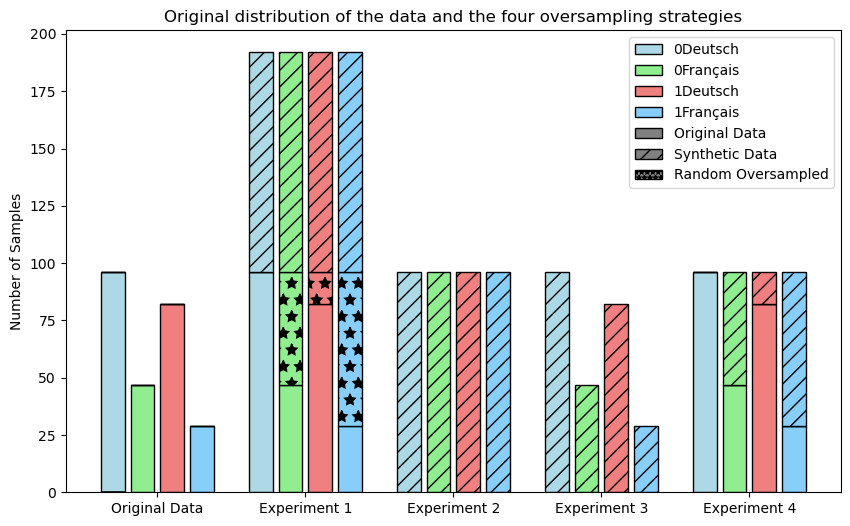

In [122]:
labels = ['0Deutsch', '0Français', '1Deutsch', '1Français']
names = ['Original Data', 'Experiment 1', 'Experiment 2', 'Experiment 3', 'Experiment 4']
group_colors = {'0Deutsch': 'lightblue', '0Français': 'lightgreen', '1Deutsch': 'lightcoral', '1Français': 'lightskyblue'}

experiments = [
    [('0Deutsch', 96), ('0Français', 47), ('1Deutsch', 82), ('1Français', 29)],
    [('0Deutsch', 192), ('0Français', 192), ('1Deutsch', 192), ('1Français', 192)],
    [('0Deutsch', 96), ('0Français', 96), ('1Deutsch', 96), ('1Français', 96)],
    [('0Deutsch', 96), ('0Français', 47), ('1Deutsch', 82), ('1Français', 29)],
    [('0Deutsch', 96), ('0Français', 96), ('1Deutsch', 96), ('1Français', 96)]]
experiments_dict = {f'{names[i]}': dict(experiment) for i, experiment in enumerate(experiments)}

original_counts_dict = dict(experiments[0])
original_max_count = max(dict(experiments[0]).values())
types = [0, 1, 2, 2, 0]

def get_counts(label, type):
    oversampling_count = 0
    if type == 0:
        original_count = original_counts_dict.get(label, 0)
        synthetic_count = counts.get(label, 0) - original_count
    if type == 1:
        original_count = original_counts_dict.get(label, 0)
        oversampling_count = original_max_count - original_count
        synthetic_count = counts.get(label, 0) - original_count - oversampling_count
    if type == 2:
        original_count = 0
        synthetic_count = counts.get(label, 0)
    return original_count , synthetic_count, oversampling_count


plt.figure(figsize=(10, 6))
for i, (name, counts) in enumerate(experiments_dict.items()):
    for j, label in enumerate(labels):
        # Position for each bar in the combined chart
        pos = j + i * (len(labels) + 1)  # Adding a space between experiments

        original_count, synthetic_count, oversampling_count = get_counts(label, types[i])

        # Plotting bars for original and synthetic data
        plt.bar(pos, original_count, color=group_colors[label], edgecolor='black')
        plt.bar(pos, oversampling_count, bottom=original_count , color=group_colors[label], hatch='*', edgecolor='black')
        plt.bar(pos, synthetic_count, bottom=original_count + oversampling_count, color=group_colors[label], hatch='//', edgecolor='black')
        

# Adding x-ticks, labels, and title
plt.xticks([i * (len(labels) + 1) + 1.5 for i in range(len(experiments_dict))], experiments_dict.keys())
plt.ylabel('Number of Samples')
plt.title('Original distribution of the data and the four oversampling strategies')

for label, color in group_colors.items():
    plt.bar(0, 0, color=color, label=label, edgecolor='black')  # Dummy bars for legend
plt.bar(0, 0, color='gray', label='Original Data', edgecolor='black')  # Dummy bar for original data
plt.bar(0, 0, color='gray', hatch='//', label='Synthetic Data', edgecolor='black')  # Dummy bar for synthetic data
plt.bar(0, 0, color='gray', hatch='***', label='Random Oversampled', edgecolor='black') 
plt.legend()

#plt.savefig('Oversampling_distribution.png', dpi=300)
plt.show()

## Fig.2 Baseline